___
### <center> <u> <h1> <strong> Diagramme Temp - Fréquence </strong> </h1> </center>

<h3>
Dans ce notebook on verra en détails :
    
<strong> 

- L'utilisation de la transformée de Fourier en Python

- La transformée de Gabor en Python
    
- L'utilisation de la transformée de Gabor pour obtenir la photographie de la transformée de Fourier à chaque instant du temps ( spectograme )


</strong>
</h3>
    
---

<h1> <strong> 1 - Importation des modules necessaires

In [1]:
################################################################################
##################  Bibliothèque utilitaire mathémlatiques  ####################
################################################################################
import numpy as np
import pandas as pd

################################################################################
##################         Bibliothèque graphique           ####################
################################################################################
import matplotlib.pyplot as plt

################################################################################
################  Bibliothèque utilitaire de fichiers audios  ##################
################################################################################
try : 
    import librosa
except :
    !pip install --upgrade pip
    !pip install librosa
    import librosa
    
################################################################################
################       Lecture d'audio à partir d'array       ##################
################################################################################
try :
    import sounddevice as sd
except :
    !pip install sounddevice
    import sounddevice as sd
    
################################################################################
##################    Bibliothèque de gestion du système    ####################
################################################################################
import os

################################################################################
######  Bibliothèque pour l'écoute de fichiers audio dans notre cas   ##########
################################################################################
import IPython.display as ipd

try :
    from tqdm import tqdm
except :
    ! pip install tqdm
    from tqdm import tqdm

<h1> <strong> 2 - Mise en situation


<h3>
    <p> Ce notebook fait suite au <a href="https://github.com/Brice-KENGNI-ZANGUIM/Signal_Processing/blob/main/2%20-%20Transform%C3%A9e%20de%20Fourier%20et%20le%20son-%20Cas%20pratique/Transform%C3%A9e%20de%20Fourier%20dans%20la%20musique.ipynb" target="_blank"> notebook précédant sur la transformée de Fourier </a> dans lequel on a décomposé un signal temporel donné en ses différentes composantes spectrales.</p>
    <p> La transformée de Fourier permet en effet d'avoir une photographie spectrale de toutes les frequences qui compose un signal sur toute sa durée. Il est possible d'obtenir une photographie 'à chaque instant' de temps en réalisant une convolution du signal en utilisant un masque caractéristique </p>
    <p> Le cas particulier où un masque gaussien est utilisé est dénomé Transformation de Gabor. Considérons le signal ci-dessous : </p>
</h3>

In [2]:
durée = 3
N_echantillon = 5000
sample_rate = N_echantillon/durée
mu = 30
t = np.linspace(0 , durée , N_echantillon)
fs = 1/(t[1] - t[0])

signal = 2*np.cos(2*np.pi*mu*t)*np.exp(-15*t/mu) 

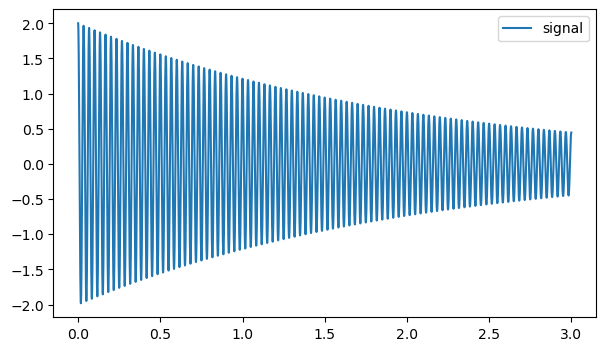

In [3]:
plt.figure(figsize = (7,4))

plt.plot(t, signal, label="signal")

plt.legend()
plt.show()

<h2> Et le masque carré suivant centré sur la seconde 1

In [4]:
def porte( centre , ouverture ) :

    return ( t > centre -ouverture/2) * (t < centre + ouverture/2)/ouverture


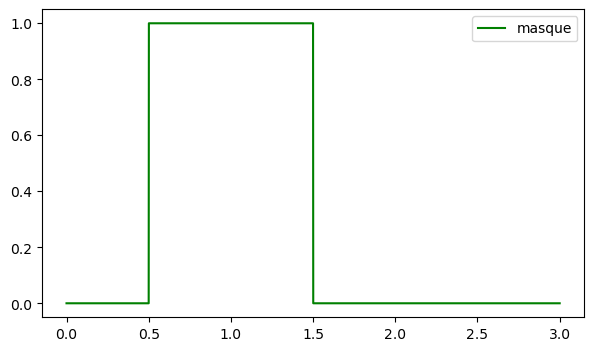

In [5]:
porte_0 = porte( 1 , durée/3)
    
plt.figure(figsize = (7,4))

plt.plot(t, porte_0, label="masque", color ="green")

plt.legend()
plt.show()

<h2> Si l'on souhaite observer le signal présécent au travers du masque ci-dessus, un peu comme si on souhaite voire le contenu d'une maison ( ici le signal ) à travers sa porte ( ici le masque ); il suffirait de réaliser un produit mathématique des deux entités

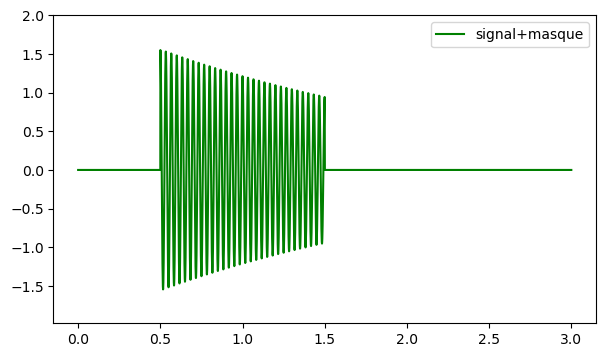

In [6]:
plt.figure(figsize = (7,4))

plt.plot(t, porte_0*signal, label="signal+masque", color ="green")

plt.ylim( signal.min(), signal.max())
plt.legend()
plt.show()

<h2> On peut donc observer le signal tout entier en déplaçant progressivement la position du masque ( son centre ) sur tout le domaine du signal de façon à avoir une photographie de signal sur chaque instant

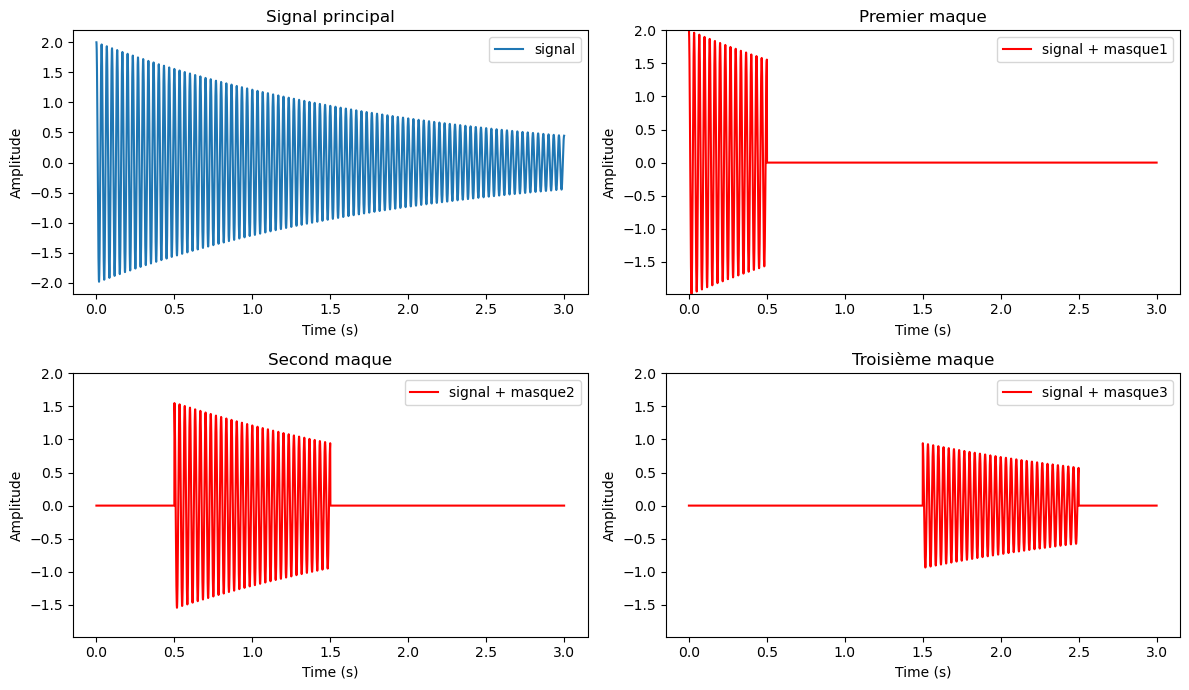

In [7]:
fig , ax = plt.subplots(2,2, figsize = (12,7))

ax[0,0].plot(t , signal , label = "signal")
ax[0,0].title.set_text("Signal principal")
ax[0,0].set_xlabel("Time (s)")
ax[0,0].set_ylabel("Amplitude")
ax[0,0].legend()

ax[0,1].plot(t , signal*porte(0 , durée/3) , label = "signal + masque1", color="red")
ax[0,1].title.set_text("Premier maque")
ax[0,1].set_xlabel("Time (s)")
ax[0,1].set_ylabel("Amplitude")
ax[0,1].set_ylim(signal.min(), signal.max())
ax[0,1].legend()

ax[1,0].plot(t , signal*porte(1 , durée/3) , label = "signal + masque2", color="red")
ax[1,0].title.set_text("Second maque")
ax[1,0].set_xlabel("Time (s)")
ax[1,0].set_ylabel("Amplitude")
ax[1,0].set_ylim(signal.min(), signal.max())
ax[1,0].legend()

ax[1,1].plot(t , signal*porte(2 , durée/3) , label = "signal + masque3", color="red")
ax[1,1].title.set_text("Troisième maque")
ax[1,1].set_xlabel("Time (s)")
ax[1,1].set_ylabel("Amplitude")
ax[1,1].set_ylim(signal.min(), signal.max())
ax[1,1].legend()

plt.tight_layout()
plt.show()

<h3> <p>Pour chacune de ces parcelles de la fonction il est possible de réaliser une Transformée de fourier pour avoir une densité spectrale des fréquences la constituant.</p> 
    <p>Et si on utilise des portes ayant des ouvertures aussi petites possible il est alors possible d'obtenir une évolution temporelle de la densité spectrale c'est à dire de mesurer, à chaque instant t, la densité de fréquence qui contitue notre signal.</p> 
    <p> On obtient alors plusieurs photographies de la densité spectrale à chaque instant de vie du signal; une sorte de film de densité spectrale; on parle alors de spectogram du signal </p>
    <p> Le masque carré utilisé ici n'est qu'un exemple parmi une infinité de masques possible. L'idée générale est de construire un masque qui permet de donner de l'important aux valeurs d'une fonction dans une région restreinte de son domaine de définition et d'ignore toutes les autres valeurs à mesure qu'on s'éloigne de ce domaine ( valeur nulle ) </p>
    

<h1> <strong> 3 - Spectramme signal simple

### La bibliothèque matplotlib possède une méthode `specgram` permettant de représenter ce spectogram

### Dans un premier temps, si notre signal pouvait être audible, on pourrait l'écouter grâce à la librairie `sounddevice` 

In [8]:
sd.play(6*signal ,fs)

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


<h2> Le spectograme du signal est alors

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun o

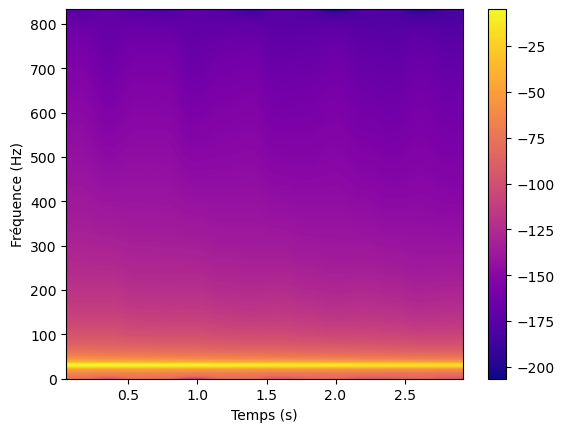

In [9]:
S , fr ,ti ,_ = plt.specgram(signal, NFFT = 512, Fs=fs,noverlap=170, cmap="plasma" )
plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")

plt.colorbar()
plt.show()

<h3> <p> On constate que dans notre signal, une fréquence faible inférieure à 50 Hz est prédominante dans le temp; ce qui correspond à la fréquence de 30 Hz attribuée à notre signal </p> 
    <p>On peut construire un autre signal avec une amplitude de fréquence qui varie dans le temps; ce qui est le cas pour la plupart des signaux audio comme de la musique par exemple </p>

<h1> <strong> 4 - Spectogramme signal complexe

In [10]:
durée = 5
N_echantillon = 15000
sample_rate = N_echantillon/durée
mu_0 = 30
mu_1 = 50
mu_2 = 70
t = np.linspace(0 , durée , N_echantillon)
fs = 1/(t[1] - t[0])

signal = 10*np.cos(2*np.pi*t*( mu_0 + (mu_1-mu_0)*t**.5 + (mu_2-mu_1)*t**2.6 ))

<h2> Une fois de plus on peut écouter le signal audio

In [11]:
sd.play(6*signal ,fs)

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred

<h2> Le spectograme du signal est alors


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


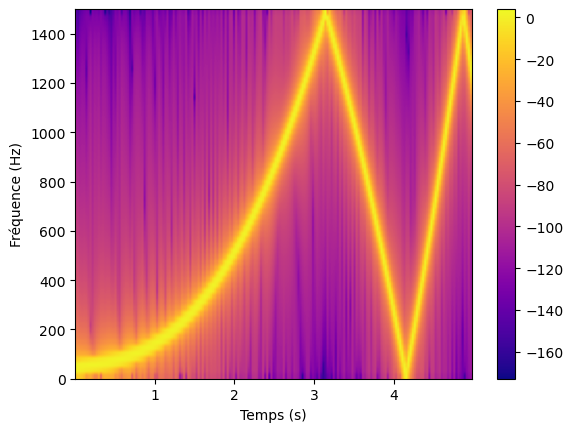

In [12]:
S , fr ,ti ,_ = plt.specgram(signal, NFFT = 128, Fs=fs,noverlap=50, cmap="plasma" )

plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")

plt.colorbar()
plt.show()

<h2> La méthode `specgram` utilisée renvoie :
    <ul> 
        <li> Le spectogram sous forme de tableau 2D </li>
        <li> La liste des fréquences discrète </li>
    </ul>  

<h1> <strong> 4 - Spectogramme de quelques sons

<h2> Dans cette partie nous allons charger quelques son qui se situent dans le repertoire `audio` du repertoire précedant et regarder à quoi ressemble leur spectogramme
    

In [13]:
audio_list = os.listdir( os.path.join(os.getcwd(), "../audio" ) )
audio_path_list = [ "/".join( ["../","audio", i] ) for i in audio_list ]


audio_discrete = [ ]
sr = 35000

for i in tqdm( range( len( audio_list ) ) ):
    x = librosa.load( audio_path_list[i] , sr = sr, duration = 1)
    audio_discrete.append( x[0] )

  0%|          | 0/13 [00:00<?, ?it/s]ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib p

<h2> Liste des audios

In [14]:
audio_list

['Bruit - pluie.wav',
 'Bruit - éminceuse.wav',
 'Bruit explosion.wav',
 'Bruit frottements_sur_table.wav',
 'Bruits_Frottemen_mains.wav',
 'Bruit_papier_déchiré.wav',
 'Bruit_symphonique.wav',
 'Bruit_toux_1.wav',
 'Bruit_toux_2.wav',
 'Bruuit_piano.wav',
 'La Lettre à Élise de Beethoven.wav',
 'Mozart - Turkish March - Piano Sonata No. 11 in A, K. 331 - Classical Music.wav',
 'Violon - Niccolo Paganini -  La campanella.wav']

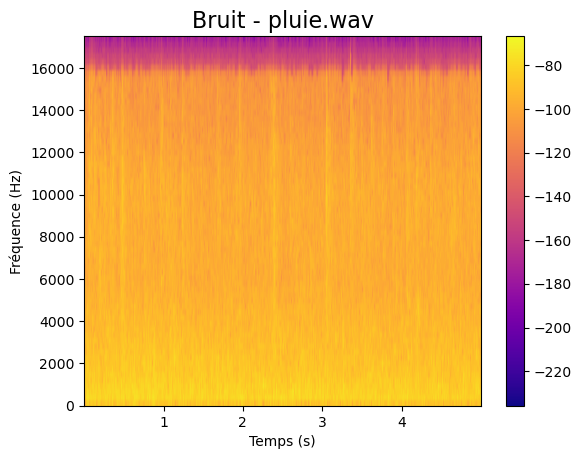

In [15]:
i = 0
S , fr ,ti ,_ = plt.specgram(audio_discrete[i], NFFT = 128, Fs=sr,noverlap=50, cmap="plasma" )

plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")
plt.title(audio_list[i] ,size = 16)

plt.colorbar()
plt.show()

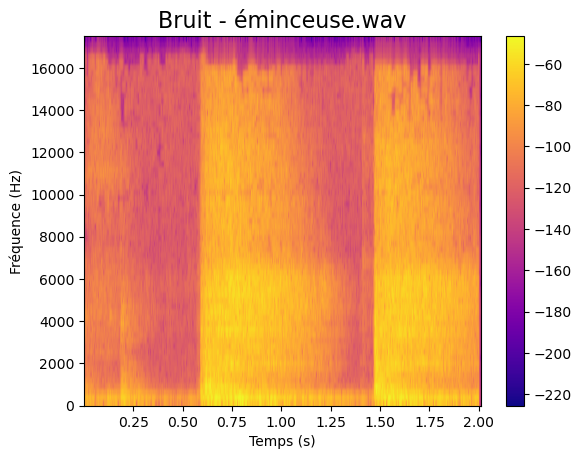

In [16]:
i = 1
S , fr ,ti ,_ = plt.specgram(audio_discrete[i], NFFT = 128, Fs=sr,noverlap=50, cmap="plasma" )

plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")
plt.title(audio_list[i] ,size = 16)

plt.colorbar()
plt.show()

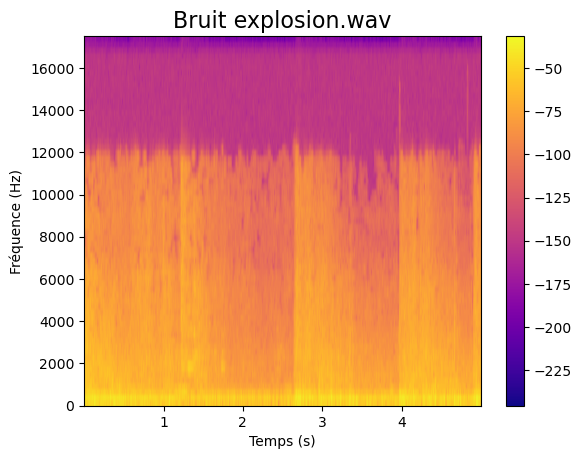

In [17]:
i = 2
S , fr ,ti ,_ = plt.specgram(audio_discrete[i], NFFT = 128, Fs=sr,noverlap=50, cmap="plasma" )

plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")
plt.title(audio_list[i] ,size = 16)

plt.colorbar()
plt.show()

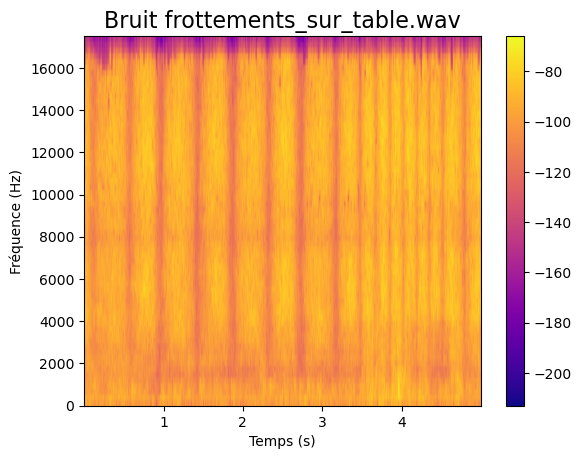

In [18]:
i = 3
S , fr ,ti ,_ = plt.specgram(audio_discrete[i], NFFT = 128, Fs=sr,noverlap=50, cmap="plasma" )

plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")
plt.title(audio_list[i] ,size = 16)

plt.colorbar()
plt.show()

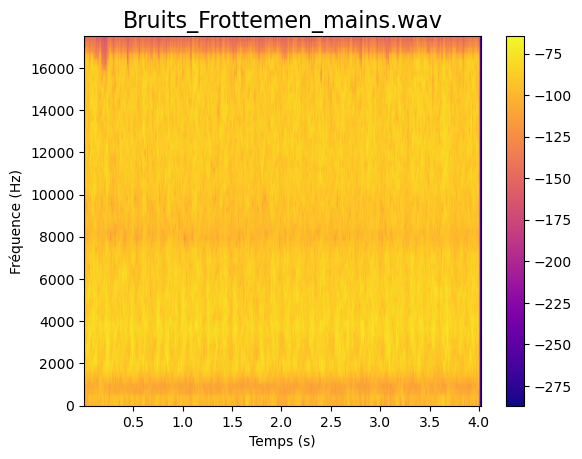

In [19]:
i = 4
S , fr ,ti ,_ = plt.specgram(audio_discrete[i], NFFT = 128, Fs=sr,noverlap=50, cmap="plasma" )

plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")
plt.title(audio_list[i] ,size = 16)

plt.colorbar()
plt.show()

/home/brice_kengni_zanguim/anaconda3/envs/Fast_API/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7628: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


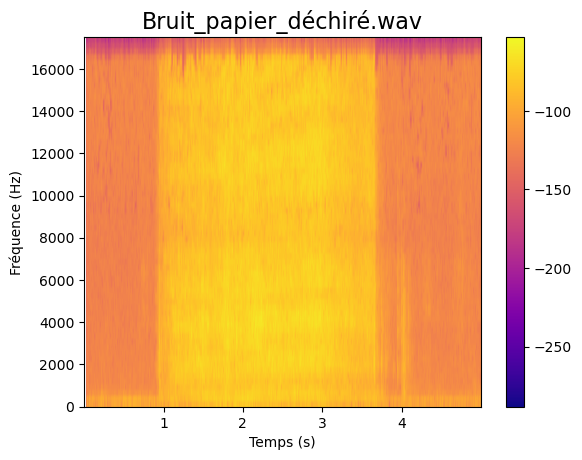

In [20]:
i = 5
S , fr ,ti ,_ = plt.specgram(audio_discrete[i], NFFT = 128, Fs=sr,noverlap=50, cmap="plasma" )

plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")
plt.title(audio_list[i] ,size = 16)

plt.colorbar()
plt.show()

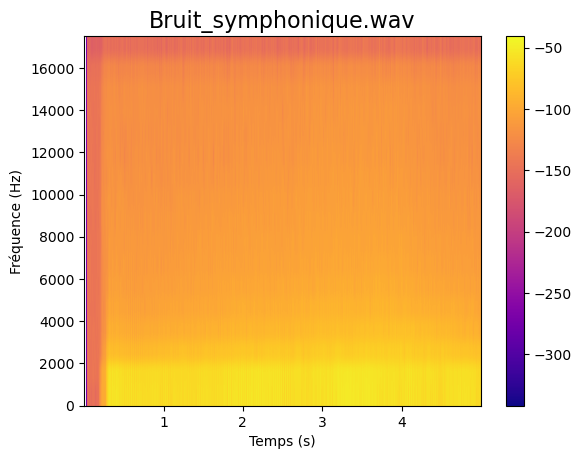

In [21]:
i = 6
S , fr ,ti ,_ = plt.specgram(audio_discrete[i], NFFT = 32, Fs=sr,noverlap=5, cmap="plasma" )

plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")
plt.title(audio_list[i] ,size = 16)

plt.colorbar()
plt.show()

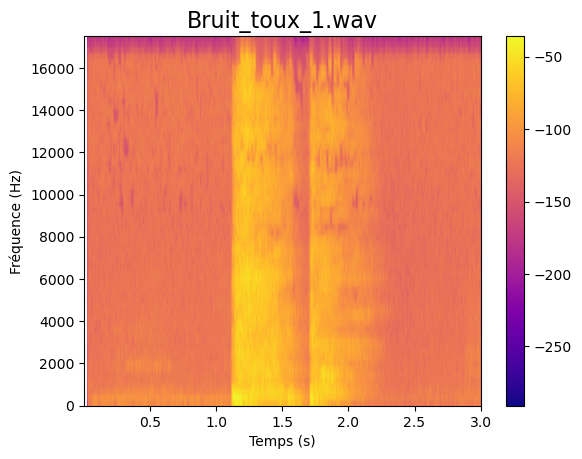

In [22]:
i = 7
S , fr ,ti ,_ = plt.specgram(audio_discrete[i], NFFT = 128, Fs=sr,noverlap=50, cmap="plasma" )

plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")
plt.title(audio_list[i] ,size = 16)

plt.colorbar()
plt.show()

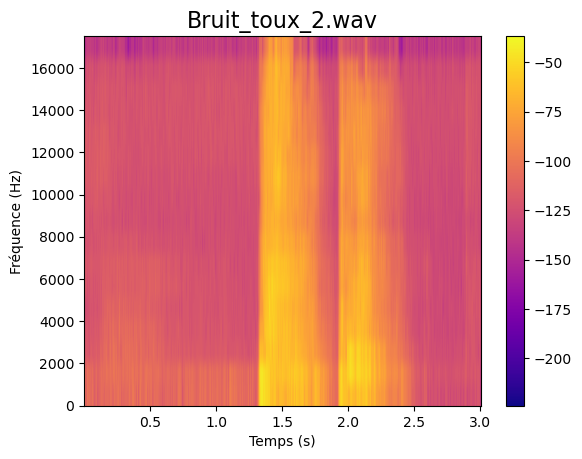

In [23]:
i = 8
S , fr ,ti ,_ = plt.specgram(audio_discrete[i], NFFT = 32, Fs=sr,noverlap=5, cmap="plasma" )

plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")
plt.title(audio_list[i] ,size = 16)

plt.colorbar()
plt.show()

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


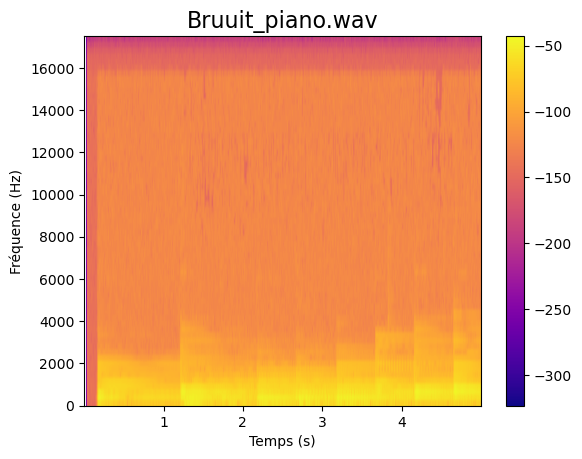

In [24]:
i = 9
S , fr ,ti ,_ = plt.specgram(audio_discrete[i], NFFT = 128, Fs=sr,noverlap=50, cmap="plasma" )

plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")
plt.title(audio_list[i] ,size = 16)

plt.colorbar()
plt.show()

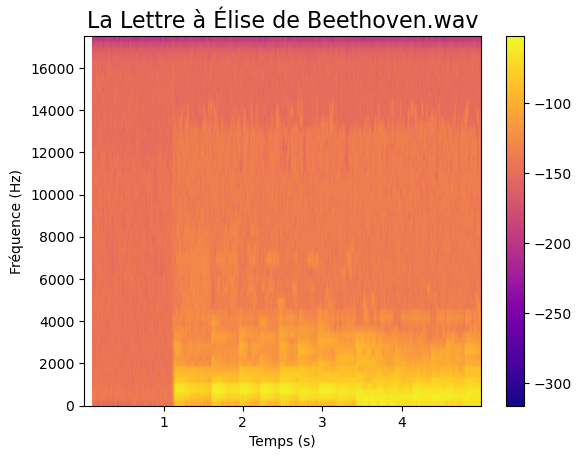

In [25]:
i = 10
S , fr ,ti ,_ = plt.specgram(audio_discrete[i], NFFT = 128, Fs=sr,noverlap=50, cmap="plasma" )

plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")
plt.title(audio_list[i] ,size = 16)

plt.colorbar()
plt.show()

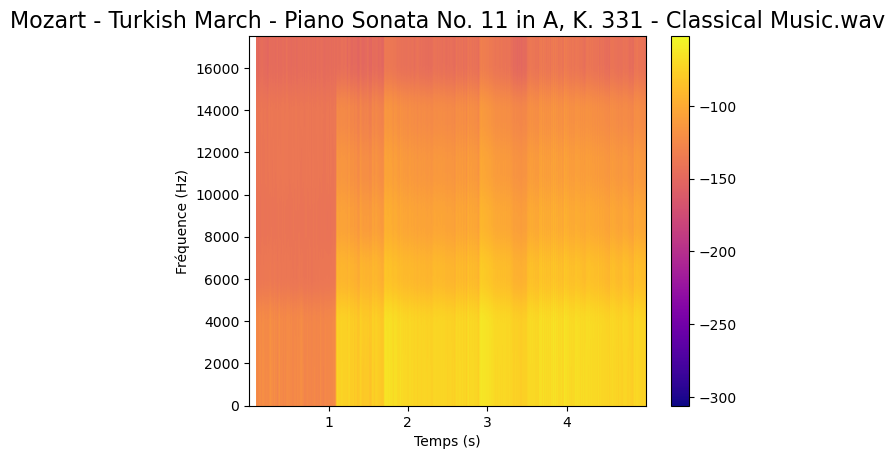

In [26]:
i = 11
S , fr ,ti ,_ = plt.specgram(audio_discrete[i], NFFT = 12, Fs=sr,noverlap=5, cmap="plasma" )

plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")
plt.title(audio_list[i] ,size = 16)

plt.colorbar()
plt.show()

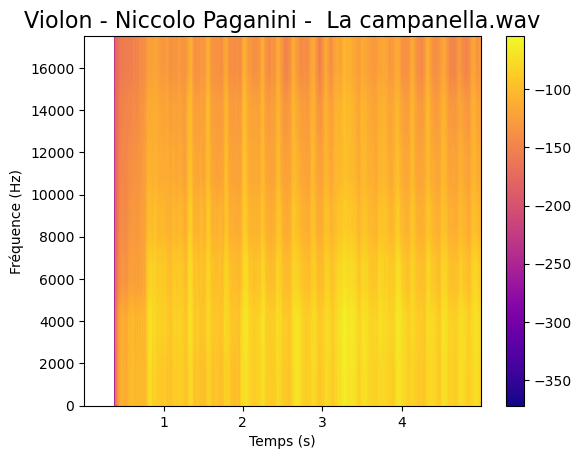

In [27]:
i = 12
S , fr ,ti ,_ = plt.specgram(audio_discrete[i], NFFT = 12, Fs=sr,noverlap=3, cmap="plasma" )

plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")
plt.title(audio_list[i] ,size = 16)

plt.colorbar()
plt.show()

---

- ## <strong> Authors </strong>

 #### <ul> <p> - <strong><a href="https://www.linkedin.com/in/brice-kengni-zanguim/" target="_blank">Brice KENGNI ZANGUIM :</a> </strong></p> <ul> Artificial Intelligence Engeneer at home and holds a PhD in Nano-physic. His research focused on using <strong>Machine Learning, Deep Learning, Signal Processing, Natural langage Processing, Computer Vision and so one</strong> to figure out how the world behave and impact human cognition. Brice KENGNI ZANGUIM has been working at home on mastering his own AI projects in many domains while seeking for a position in a company. </ul></ul>


---

- ## <strong> Other Contributors </strong>

#### <ul>None</ul>

---

- ## <strong> Change Log </strong>

|  Date (DD-MM-YYYY) |  Version | Changed By  |  Change Description |  Purpose  |
|---|---|---|---|---|
| 16- 03 - 2023 | 1.0 | Brice KENGNI ZANGUIM | Updated the file | Mem,save |
| 18- 03 - 2023 | 1.0 | Brice KENGNI ZANGUIM | Updated the file | Mem,save |
|-|-|-|-|
|   |   |   |   |   |

### <h3 align="center"> © BKZ Corporation 2023. All rights reserved. <h3/>
---